In [17]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from scipy.stats import sem
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import division
from matplotlib.lines import Line2D
from unbalanced_dataset import SMOTE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

In [18]:
#plot feature importance
def plot_feature_importance(names, feature_matrix, title):
    for i in range(0,len(feature_matrix)):
        name = names[i]
        # Plot the feature importances of the forest
        plt.figure()
        plt.title(title+name)
        '''Boxplots'''
        df = pd.DataFrame(feature_matrix[i], columns=labels[0:len_feature])
        med = df.median()
        med.sort()
        newdf = df[med.index]
        plt.boxplot(np.array(newdf),'',vert=False)
        plt.yticks(range(1,len_feature+1), med.index, rotation=0)
        plt.xlabel("Feature importance")
        plt.show()

In [19]:
#creat labels for data
def add_Names(filename, selected_features, ):
    # Start with an empty dictionary
    stats = {}
    for line in open(filename):
        # Split the config.dat file with delimiter ','; key is the feature number and value is feature name
        line = line.replace("'", "")
        temp = line.rstrip().split(',')
        stats[temp[0]] = temp[1]
    features = []
    for feature in selected_features:
        features.append(stats[str(feature)])
    features.append(class_label)
    return features

#Select data based on objects' labels (subset for certain classes)
def selectdata(data, Selected_Class):
    dataF = pd.DataFrame()
    i = 0
    for c in Selected_Class:
        dataF =  dataF.append(data[data[class_label] == c])
        #dataF.loc[data[class_label] == c,class_label] = i
        i+=1
    return dataF

def test_train_label(X, split, offset):
    len_feature = len(X.columns) - offset
    train, test = train_test_split(X, train_size=(split/100))
    X_train = train.iloc[:,range(0,len_feature)]
    y_train= train[class_label]
    X_test = test.iloc[:,range(0,len_feature)]
    y_test = test[class_label]
    return X_train,y_train,X_test,y_test

def normalize_data_with_label(data):
    df = data.iloc[:,range(0,len_feature)]
    data_norm = (df - df.mean()) / (df.max() - df.min())
    data_norm[class_label] = data[class_label]
    return data_norm

#minus mean and divided by standard deviation
def normalize_data_with_label2(data):
    df = data.iloc[:,range(0,len_feature)]
    data_norm = (df - df.mean()) / df.std()
    data_norm[class_label] = data[class_label]
    return data_norm

def sample_wo_replacement(data, size):
    o_data = pd.DataFrame()
    for c in Selected_Class:
        temp = data[data[class_label] == c]
        class_size = len(temp)
        if size > class_size:
            indexes = np.random.choice(temp.index, size-class_size, replace=True)
            temp = temp.append(temp.ix[indexes])
        else:
            indexes = np.random.choice(temp.index, size, replace=False)
            temp = temp.ix[indexes]
        o_data = o_data.append(temp)
    return o_data

In [20]:
#in-domain classification with data as all labelled in one survey and Clf as classifier
def learning_curve(data, Clf, sample_method):
    Learning_accuracies = []
    Feature_importance = []
    X = np.array(data.iloc[:,range(0,len_feature)])
    y = data[class_label]
    y = y.values
    test_smaller_class = np.count_nonzero(y==1)
    if sample_method == "SMOTE":
        ratio = float(np.count_nonzero(y==0)) / float(test_smaller_class)
        smote = SMOTE(ratio=ratio, verbose=verbose, kind='regular')
        X, y = smote.fit_transform(X, y)
        y = y.astype(int)     
    for split in range(start_size,end_size,bins):
        scores = []
        importances = []
        #performing same size sampling for iter_times1 times
        for i in range(0,iter_time1):
            if sample_method == "under":
                new_data = sample_wo_replacement(data, test_smaller_class)
                X = np.array(new_data.iloc[:,range(0,len_feature)])
                y = new_data[class_label]
                y = y.astype(int)  
            #performing test, training split for iter_times2 times
            for j in range(0,iter_time2):
                X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=(split/100))               
                Clf.fit(X_train, y_train)
                scores.append(Clf.score(X_test, y_test))
                if (type(Clf) == type(rfc)):
                    importances.append(Clf.feature_importances_)
        ave_score = np.mean(scores)
        Learning_accuracies.append(ave_score)
        if (type(Clf) == type(rfc)):
            ave_f_importance =  np.mean(np.array(importances), axis=0)
            Feature_importance.append(ave_f_importance)
    return Learning_accuracies, Clf, Feature_importance

In [21]:
selected_features = range(1,22)
selected_features.remove(15)
len_feature = len(selected_features)
filename = 'config.dat'
class_label = "class"
labels = add_Names(filename,selected_features)

In [22]:
#constant value
start_size = 50
end_size = 100
bins = 10
iter_time1 = 10
iter_time2 = 5

In [23]:
svc = LinearSVC()
rfc = RandomForestClassifier()
verbose = False

In [24]:
norm = True
balance = True
dim_red = True

In [28]:
csdr2 = pd.read_csv('CSDR2_lc_data.csv')
ptfr = pd.read_csv('R_PTF_lc_features.csv')
lineardb = pd.read_csv('Linear_lc_over40.csv')
Selected_Class = [1,2,4,5,6,8]

In [29]:
print "CSDR2: ", Counter(csdr2[class_label])
print "PTFr: ", Counter(ptfr[class_label])
print "common: ", Counter((csdr2[csdr2.index.isin(ptfr.index.values)])[class_label])

CSDR2:  Counter({1: 30745, 5: 5466, 2: 4683, 4: 2431, 8: 1521, 13: 512, 6: 502})
PTFr:  Counter({1: 10365, 5: 1990, 2: 1695, 4: 649, 8: 522, 6: 169, 13: 68})
common:  Counter({1: 10365, 5: 1990, 2: 1695, 4: 649, 8: 522, 6: 169, 13: 68})


In [30]:
if norm:
    csdr2_norm = normalize_data_with_label(csdr2)
if balance:
    csdr2_b = sample_wo_replacement(csdr2, 500)
if dim_red:
    X = normalize_data_with_label2(csdr2).iloc[:,range(0,len_feature)]
    pca = PCA().fit(X)
    total_var = 0
    var_ratio = pca.explained_variance_ratio_
    for i in range(0, len(var_ratio)):
        total_var = total_var+var_ratio[i]
        if (total_var >= 0.9):
            break
    k_components = i+1
    csdr2_p = pd.DataFrame(PCA(n_components=k_components).fit_transform(X), index=csdr2.index.values)

-----------------------------------------Get the list of missing object IDs that are in PTF but not in CRTS-----------------------------------------

In [22]:
missing_list = pd.read_csv('missing_list')
csdr2 = csdr2[csdr2.index.isin(ptfr.index.values)]
missing = ptfr[~ptfr.index.isin(csdr2.index.values)]
print ptfr.shape, csdr2.shape, missing_list.shape, missing.shape

(33958, 21) (33786, 21) (234, 1) (172, 21)


In [18]:
missing = missing_list[missing_list['IDs'].isin(missing.index.values)]
missing.to_csv("missing_ids_PTF-CRTS.csv", index=False)

In [23]:
missing = missing_list[~missing_list['IDs'].isin(missing.index.values)]
missing.to_csv("missing_ids_PTF-CRTS2.csv", index=False)
#proceeds to Label_data_plot_lc

-----------------------------------------END Get the list of missing object IDs that are in PTF but not in CRTS-----------------------------------------

In [11]:
#Kmeans example
for k in range(4,12):
    k_mean = KMeans(n_clusters=k)
    X = csdr2_p
    k_mean.fit(X)
    A = k_mean.predict(X)
    X[class_label] = A
    X["Real_"+class_label] = csdr2[class_label]
    assigned_c = []
    accuracies = []
    for c in Selected_Class:
        temp = X[X["Real_"+class_label] == c]
        class_match = temp[class_label]
        pair = Counter(class_match).most_common()[0]
        major_class, major_num = pair
        assigned_c.append(major_class)
        accuracies.append(major_num / len(temp))
    ave_accuracy = np.mean(accuracies)
    print k, ave_accuracy

4 0.702856348689
5 0.81536240449
6 0.809752262761
7 0.754808357029
8 0.754791401895
9 0.751370028942
10 0.774301571814
11 0.704493979415


In [209]:
random = 100
interested_class = 13
start_K = 2
end_K =11

In [155]:
table = pd.DataFrame(columns=Selected_Class)
indexes = []
for k in range(start_K,end_K):
    index = []
    for i in range(0, k):        
        table.loc[k*10+i] = np.zeros(7)
    k_mean = KMeans(n_clusters=k, random_state=random)
    X = csdr2_p
    k_mean.fit(X)
    A = k_mean.predict(X)
    X[class_label] = A
    X["Real_"+class_label] = csdr2[class_label]
    assigned_c = []
    accuracies = []
    table.loc[str(k)+'completeness'] = np.zeros(7)
    for c in Selected_Class:
        temp = X[X["Real_"+class_label] == c]
        class_match = temp[class_label]
        count = Counter(class_match).most_common()
        index.append(zip(temp.index.values, temp[class_label]))
        total = 0
        for i in range(0,len(count)):
            pred_c, num = count[i]
            if i == 0:
                Max_value = num
            total+=num
            (table.loc[k*10+pred_c])[c] = num
        #Add completeness
        (table.loc[str(k)+'completeness'])[c] = Max_value/total
    indexes.append(index)
#Add comtamination:
table['contamination'] = (table.sum(axis = 1) - table.max(axis = 1)) / table.sum(axis = 1) 

-----------------------------------find important features which cause the separation within certain class with some K-----------------------------------

In [183]:
#Use random forest to test feature importance for interested_class
def important_feature_separate_classX_withK(classX, K, data):
    index = Selected_Class.index(classX)
    pred_index_for_classX = []
    for i in range(0,len(indexes)):
        temp = indexes[i]
        pred_index_for_classX.append(temp[index])
    #during k = K, split into how many classes
    class_interested = np.array(pred_index_for_classX[K-2]) #since K starts with 2
    count_class = Counter(class_interested[:,1]).most_common() #count how many clusters formed

    class_indexes = []
    for i in range(0,len(count_class)):
        pred_c, num = count_class[i]
        class_c_indexes = class_interested[class_interested[:,1]==pred_c]
        class_indexes.append(class_c_indexes[:,0]) #only append the index
    
    classX_data = pd.DataFrame(columns=data.columns)
    for i in range(0,len(class_indexes)):
        temp = data[csdr2_norm.index.isin(class_indexes[i])]
        temp[class_label] = i
        classX_data = classX_data.append(temp)
    
    X_train,y_train,X_test,y_test = test_train_label(classX_data, 50, 1)
    feature_importances = []
    scores = []
    for i in range(0, 10):
        rfc.fit(X_train,y_train)
        scores.append(rfc.score(X_test,y_test))
        feature_importances.append(rfc.feature_importances_)
    ave_score = np.mean(scores)
    return rfc, ave_score, feature_importances

In [217]:
for K in range(start_K,end_K):
    for classX in Selected_Class:
        rfc, ave_score, feature_importances = important_feature_separate_classX_withK(classX,K,csdr2_norm)
        df = pd.DataFrame([np.mean(feature_importances,axis=0), sem(feature_importances)], columns=labels[0:len_feature], index = ['feature importance','stderr'])
        med = df.iloc[1,:]
        med.sort(ascending = False)
        newdf = df[med.index]
        newdf.to_csv("feature_importances/K%d_Class%d" %(K, classX))

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


---------------------------------------------------plotting the feature importance and data separation within a class---------------------------------------------------

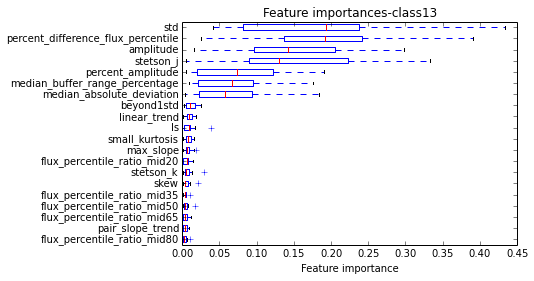

In [181]:
names = ["class13"]
for i in range(0,len(names)):
    name = names[i]
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances-"+name)
    '''Boxplots'''
    df = pd.DataFrame(feature_matrix[i], columns=labels[0:len_feature])
    med = df.median()
    med.sort()
    newdf = df[med.index]
    plt.boxplot(np.array(newdf),'',vert=False)
    plt.yticks(range(1,len_feature+1), med.index, rotation=0)
    plt.xlabel("Feature importance")
    plt.show()

In [ ]:
#scatterplot
colors = ['r','g','b','c']
feature_names = ['stetson_j','median_absolute_deviation','std']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(0,len(class_indexes)):
    temp = csdr2[csdr2.index.isin(Test[Test[class_label]==i].index.values)]
    f1 = temp[feature_names[0]] 
    f2 = temp[feature_names[1]]
    f3 = temp[feature_names[2]]
    ax.scatter(f1, f2, f3, c=colors[i])
    #plt.scatter(f1, f2, color=colors[i])
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])
#plt.ylim(-100,600)
plt.show()

------------------------------------------------END plotting the feature importance and data separation within a class------------------------------------------------

-------------------------------------END find important features which cause the separation within certain class with some K--------------------------------------------

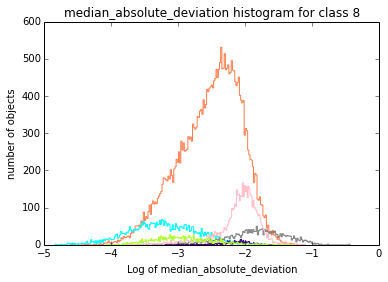

In [33]:
#plot histogram for each class based on certain features
feature_name = 'median_absolute_deviation'
color_names = ['coral', 'pink', 'aqua', 'greenyellow', 'grey', , 'indigo']
index = 0
for i in Selected_Class:
    ls = np.log((selectdata(csdr2, [i]))[feature_name])
    plt.hist(np.array(ls), bins =200, color=color_names[index], histtype='step')
    index = index +1
plt.xlabel("Log of %s" %feature_name)
plt.ylabel("number of objects")
plt.title("%s histogram for class %d" %(feature_name, i))
plt.show()

---------Below are domain adaptation applications using the small set of data (around 500 objects from CRTS and PTFr), which uses SMOTE and under sampling-----------

--------------------------------------------------------in-domain classification classification-----------------------------------------

In [5]:
#add lables to each dataset
ptfr = pd.read_csv('R_PTF_features_labeled.csv',names=labels)
crts = pd.read_csv('CRTS_features_labeled.csv',names=labels)

In [7]:
#select subset based on class' labels
'''PUT larger class at front (index 0)'''
Selected_Class = {"PUL", "ECL"}
ptfr = selectdata(ptfr, Selected_Class)
crts = selectdata(crts, Selected_Class)

In [28]:
#normalize the data
ptfr_norm = normalize_data_with_label(ptfr)
crts_norm = normalize_data_with_label(crts)

In [9]:
#output the table
ptfr.to_csv("PTFr_selected_class_numeric_labels.csv")
crts.to_csv("CRTS_selected_class_numeric_labels.csv")
ptfr_norm.to_csv("PTFr_norm_selected_class_numeric_labels.csv")
crts_norm.to_csv("CRTS_norm_selected_class_numeric_labels.csv")

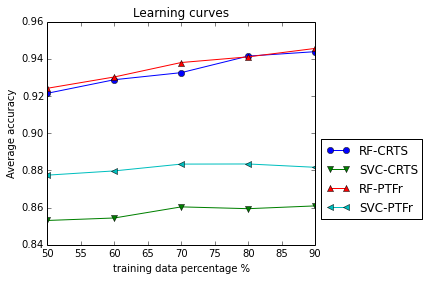

In [34]:
#in-domain classification learning curve
fig = plt.figure()
ax = fig.add_subplot(111)
i = 0
sample_method = "SMOTE"
for clf, name, data in [(rfc, 'RF-CRTS', crts),
                        (svc, 'SVC-CRTS',crts_norm),
                        (rfc, 'RF-PTFr', ptfr),
                        (svc, 'SVC-PTFr',ptfr_norm)]:
    Learning_accuracies, clf, Feature_importance = learning_curve(data,clf,sample_method)
    ax.plot(range(start_size,end_size,bins), Learning_accuracies, "s-",
             label="%s" % (name, ), marker = Line2D.filled_markers[i])
    i += 1

ax.set_title("Learning curves")
ax.set_xlabel("training data percentage %")
ax.set_ylabel("Average accuracy")

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()

In [46]:
#generate feature importance matrix
feature_matrix = []
for clf, name, data in [(rfc, 'RF-CRTS', crts),
                        (rfc, 'RF-PTFr', ptfr)]:
    Learning_accuracies, clf, Feature_importance = learning_curve(data,clf,"SMOTE")
    feature_matrix.append(np.array(Feature_importance))

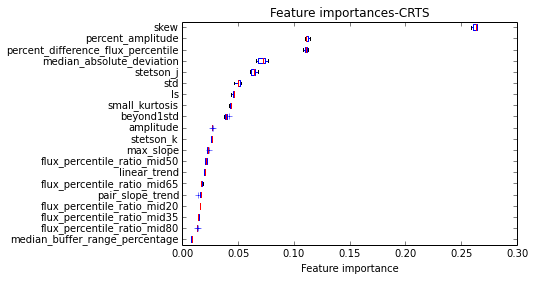

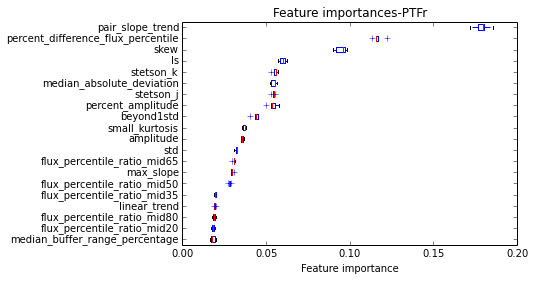

In [83]:
#plot feature importance
names = ["CRTS","PTFr"]
for i in range(0,len(feature_matrix)):
    name = names[i]
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances-"+name)
    '''Boxplots'''
    df = pd.DataFrame(feature_matrix[i], columns=labels[0:len_feature])
    med = df.median()
    med.sort()
    newdf = df[med.index]
    plt.boxplot(np.array(newdf),'',vert=False)
    plt.yticks(range(1,len_feature+1), med.index, rotation=0)
    plt.xlabel("Feature importance")
    plt.show()


--------------------------------------------------------Domain Adaptation Baseline Test 1 S-to-Target--------------------------------------------------

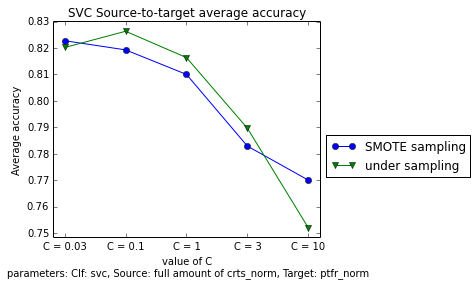

In [122]:
#Source-to-target test-svc
fig = plt.figure()
ax = fig.add_subplot(111)
index = 0
for sampling_method in ['SMOTE','under']:
    Scores = []
    names = []
    for c in [0.03,0.1,1,3,10]:
        Ave_scores = []
        for i in range(0,100):
            svc = LinearSVC(C=c)
            score, Clf, Feature_importance = Domain_Adaptation(crts_norm, ptfr_norm, svc, sampling_method, 1)
            Ave_scores.append(score)
        names.append("C = %s" %c)
        Scores.append(Ave_scores)
    ax.plot(range(len(names)), np.mean(Scores, axis=1),"s-",label="%s sampling" % (sampling_method, ), 
            marker = Line2D.filled_markers[index])
    index += 1
    
plt.title("SVC Source-to-target average accuracy")
plt.xlabel("value of C")
plt.ylabel("Average accuracy")
plt.xticks(range(len(names)),names)
plt.figtext(.02, .02, "parameters: Clf: svc, Source: full amount of crts_norm, Target: ptfr_norm")
plt.subplots_adjust(bottom=0.15)
plt.margins(0.05)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()

In [42]:
feature_matrix = []
names = ['SMOTE','under']
for sampling_method in names:   
    Feature_importance = []
    Ave_scores = []
    for i in range(0,15):
        score, Clf, f_importance = Domain_Adaptation(crts, ptfr, rfc, sampling_method, 1)
        Ave_scores.append(score)
        Feature_importance.append(f_importance)
    feature_matrix.append(Feature_importance)
    print "RFC Source-to-target average accuracy with %s sampling: " % sampling_method, np.mean(Ave_scores)

RFC Source-to-target average accuracy with SMOTE sampling:  0.817647058824
RFC Source-to-target average accuracy with under sampling:  0.785369532428


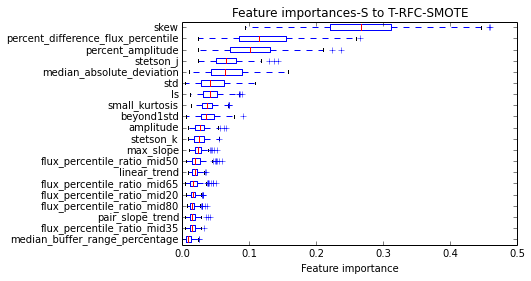

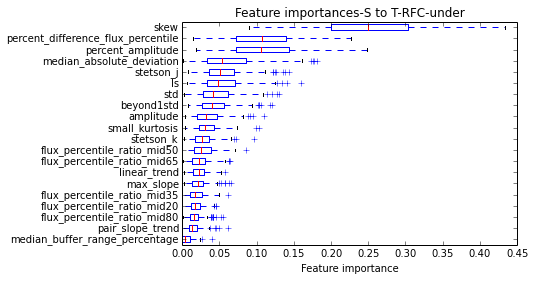

In [124]:
title = "Feature importances-S to T-RFC-"
plot_feature_importance(names, feature_matrix, title)

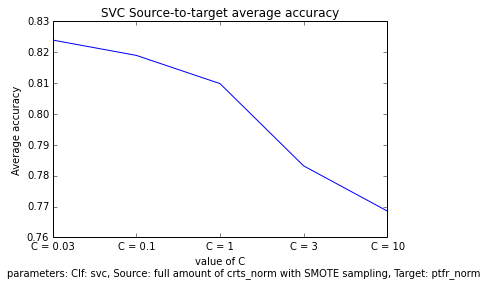

In [68]:
'''Ignore
#plot of source-to-target test with different C values
#parameters: Clf: svc, Source: full amount of crts_norm with SMOTE sampling, Target: ptfr_norm
plt.plot(range(len(names)), np.mean(Scores, axis=1))
plt.title("SVC Source-to-target average accuracy")
plt.xlabel("value of C")
plt.ylabel("Average accuracy")
plt.xticks(range(len(names)),names)
plt.figtext(.02, .02, "parameters: Clf: svc, Source: full amount of crts_norm with SMOTE sampling, Target: ptfr_norm")
plt.subplots_adjust(bottom=0.15)
plt.show()

--------------------------------------------------------Domain Adaptation Baseline Test 2 (S+some T) to Target--------------------------------------------------

--------------------------------------------------------Domain Adaptation Baseline Test 3 Target to Target--------------------------------------------------

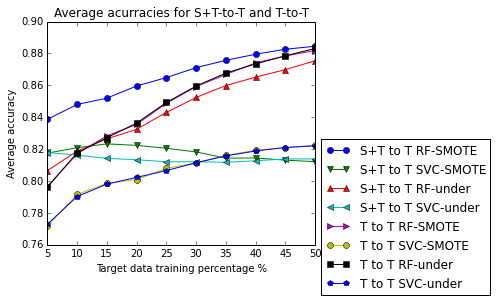

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
index = 0
'''Domain Adaptation Baseline Test 2 (S+some T) to Target'''
for clf, name, sample_method in [(rfc, 'RF', "SMOTE"),
                        (LinearSVC(C=1), 'SVC',"SMOTE"),
                        (rfc, 'RF', "under"),
                        (LinearSVC(C=1), 'SVC',"under")]:
    if type(clf) == type(svc):
        S_data = crts_norm
        T_data = ptfr_norm
    elif type(clf) == type(rfc):
        S_data = crts
        T_data = ptfr
    Learning_accuracies = []
    for i in range(0,iter_time1):
        accuracies, clf, Feature_importance = Domain_Adaptation(S_data, T_data, clf, sample_method, 2)
        Learning_accuracies.append(accuracies)
    ax.plot(range(start_size,end_size,bins), np.mean(Learning_accuracies, axis=0), "s-",
             label="S+T to T %s-%s" % (name,sample_method), marker = Line2D.filled_markers[index])
    index += 1

'''Domain Adaptation Baseline Test 2 Target to Target'''

for clf, name, data, sample_method in [(rfc, 'RF-SMOTE', ptfr, "SMOTE"),
                        (svc, 'SVC-SMOTE', ptfr_norm, "SMOTE"),
                        (rfc, 'RF-under', ptfr, "under"),
                        (svc, 'SVC-under', ptfr_norm, "under")]:
    Learning_accuracies = []
    for i in range(0,iter_time1):
        accuracies, clf, Feature_importance = Domain_Adaptation(pd.DataFrame(), data, clf, sample_method, 2)
        Learning_accuracies.append(accuracies)
    ax.plot(range(start_size,end_size,bins), np.mean(Learning_accuracies,axis=0), "s-",
             label="T to T %s" % (name, ), marker = Line2D.filled_markers[index])
    index += 1

ax.set_title("Average acurracies for S+T-to-T and T-to-T")
ax.set_xlabel("Target data training percentage %")
ax.set_ylabel("Average accuracy")

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()

In [99]:
def Domain_Adaptation(S_data, T_data, Clf, sample_method, number):
    test_smaller_class = len(T_data[T_data[class_label]==1])
    Feature_importance = []
    if S_data.empty:
        X_train = np.empty((0,len_feature), float)
        y_train = []
    else:
        y_train = S_data[class_label]
        y_train = y_train.values
        if sample_method == "SMOTE":
            ratio = float(np.count_nonzero(y_train==0)) / float(np.count_nonzero(y_train==1))
            smote = SMOTE(ratio=ratio, verbose=verbose, kind='regular')
            X_train = np.array(S_data.iloc[:,range(0,len_feature)])
            X_train, y_train = smote.fit_transform(X_train, y_train)       
        elif sample_method == "under":
            S_data = sample_wo_replacement(S_data, np.count_nonzero(y_train==1))
            X_train = np.array(S_data.iloc[:,range(0,len_feature)])
            y_train = S_data[class_label]
        y_train = y_train.astype(int)
    if number == 1:
        Clf.fit(X_train, y_train)
        X_test = np.array(T_data.iloc[:,range(0,len_feature)])
        y_test = T_data[class_label]
        y_test = y_test.values
        y_test = y_test.astype(int)
        score = Clf.score(X_test, y_test)
        if (type(Clf) == type(rfc)):
            Feature_importance = Clf.feature_importances_
        return score, Clf, Feature_importance
    elif number == 2:
        Learning_accuracies = []
        for split in range(start_size,end_size,bins):
            size = ((split/100)*len(T_data))/2
            scores = []
            importances = []
            #performing target selection sampling for iter_time2 times
            for i in range(0,iter_time2):
                #size: the size of a single class, so len(Train_target) will be size*2
                if (size > test_smaller_class/2):
                    Test_target = sample_wo_replacement(T_data, test_smaller_class/2)
                    Train_target = sample_wo_replacement(T_data[~T_data.index.isin(Test_target.index.values)],size)
                    Test_target = Test_target.append(T_data[np.logical_and(
                                ~T_data.index.isin(Train_target.index.values), 
                                ~T_data.index.isin(Test_target.index.values))])
                else:
                    Train_target = sample_wo_replacement(T_data, size)
                    Test_target = T_data[~T_data.index.isin(Train_target.index.values)]
                    
                new_X_train = np.append(X_train, np.array(Train_target.iloc[:,range(0,len_feature)]), axis=0)
                new_y_train = np.append(y_train, Train_target[class_label])
                new_y_train = new_y_train.astype(int)
                X_test = np.array(Test_target.iloc[:,range(0,len_feature)])
                y_test = Test_target[class_label]
                y_test = (y_test.values).astype(int) 
                Clf.fit(new_X_train, new_y_train)
                scores.append(Clf.score(X_test, y_test))
                if (type(Clf) == type(rfc)):
                    importances.append(Clf.feature_importances_)
            ave_score = np.mean(scores)
            Learning_accuracies.append(ave_score)
            if (type(Clf) == type(rfc)):
                ave_f_importance =  np.mean(np.array(importances), axis=0)
                Feature_importance.append(ave_f_importance)
        return Learning_accuracies, Clf, Feature_importance

-----------Domain Adaptation Baseline Test 2 (S+some T) to Target--------Domain Adaptation Baseline Test to Target to Target-------Selecting Data-----------

eliminate part of the source data for training which has the same ID as the test data, plot with errorbar

In [96]:
def Domain_Adaptation2(S_data, T_data, Clf, sample_method):
    test_smaller_class = len(T_data[T_data[class_label]==1])
    target_len = len(T_data)
    Learning_accuracies = []
    Feature_importance = []
    n = 10 #select n% data of target data for testing
    reserve_len = (n/100)*target_len 
    # if data is not enough, reserve how many data for testing for each class
    # is also the length of how many test_target data we select for each run for both class
    # for now, reserve_len is close to test_smaller_class/2
    for split in range(start_size,end_size,bins):
        learn_accuracy = []
        importances = []
        size = ((split/100)*len(T_data))/2
        #perform iter_time1 selecting Target_train
        for i in range(0,iter_time1):
            #size: the size of a single class, so in total, target data for training will be size*2
            scores = []
            #if data is enough
            if size < test_smaller_class/2:
                Target_train = sample_wo_replacement(T_data, size)
            #if data is not enough
            else:
                target_reserve = sample_wo_replacement(T_data, reserve_len)
                target_reserve = target_reserve[target_reserve[class_label] == 1]#only reserve the data for the smaller class
                Target_train = sample_wo_replacement(T_data[~T_data.index.isin(target_reserve.index.values)], size)
                #print "size:", size, " Target_train:", len(Target_train), "target_reserve:", len(target_reserve)
            #perform iter_time2 slecting Test_target
            for i in range(0,iter_time2):
                #print "size:", size, " Target_train:", len(T_data[~T_data.index.isin(Target_train.index.values)])
                Test_target = sample_wo_replacement(T_data[~T_data.index.isin(Target_train.index.values)], 
                                                    reserve_len/2)
                
                X_test = np.array(Test_target.iloc[:,range(0,len_feature)])
                y_test = Test_target[class_label].values
                y_test = y_test.astype(int)
                #print len(y_test), np.count_nonzero(y_test==0), np.count_nonzero(y_test==1)
                if S_data.empty:
                    Source_train = pd.DataFrame()
                else:    
                    Source_train = S_data[~S_data.index.isin(Test_target.index.values)]
                Train_data = Target_train.append(Source_train)
                y_train = Train_data[class_label].values
                if sample_method == "SMOTE":
                    #does not change Train_data
                    ratio = float(np.count_nonzero(y_train==0)) / float(np.count_nonzero(y_train==1))
                    smote = SMOTE(ratio=ratio, verbose=verbose, kind='regular')
                    X_train = np.array(Train_data.iloc[:,range(0,len_feature)])
                    X_train, y_train = smote.fit_transform(X_train, y_train)       
                elif sample_method == "under":
                    #do change Train_data
                    Train_data = sample_wo_replacement(Train_data, np.count_nonzero(y_train==1))
                    X_train = np.array(Train_data.iloc[:,range(0,len_feature)])
                    y_train = Train_data[class_label].values
                y_train = y_train.astype(int)
                Clf.fit(X_train, y_train)
                scores.append(Clf.score(X_test, y_test))
                if (type(Clf) == type(rfc)):
                    importances.append(Clf.feature_importances_)
            learn_accuracy.append(np.mean(scores))
        if (type(Clf) == type(rfc)):
            ave_f_importance =  np.mean(np.array(importances), axis=0)
            Feature_importance.append(ave_f_importance)
        Learning_accuracies.append(np.mean(learn_accuracy))
    return Learning_accuracies, Clf, Feature_importance

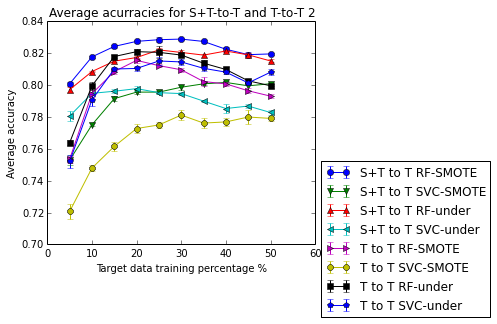

In [146]:
fig = plt.figure()
ax = fig.add_subplot(111)
runs = 4
Learning_curves = []
labels = []
for run in range(0,runs):
    '''Domain Adaptation Baseline Test 2 (S+some T) to Target'''
    Learning_curve = []
    for clf, name, sample_method in [(rfc, 'RF', "SMOTE"),
                            (LinearSVC(C=1), 'SVC',"SMOTE"),
                            (rfc, 'RF', "under"),
                            (LinearSVC(C=1), 'SVC',"under")]:
        if type(clf) == type(svc):
            S_data = crts_norm
            T_data = ptfr_norm
        elif type(clf) == type(rfc):
            S_data = crts
            T_data = ptfr
        Learning_accuracies, clf, Feature_importance = Domain_Adaptation2(S_data, T_data, clf, sample_method)
        Learning_curve.append(Learning_accuracies)
        labels.append("S+T to T %s-%s" % (name,sample_method))
        '''
        ax.plot(range(start_size,end_size,bins), Learning_accuracies, "s-",
                 label="S+T to T %s-%s" % (name,sample_method), marker = Line2D.filled_markers[index])
        index += 1
        '''

    '''Domain Adaptation Baseline Test 2 Target to Target'''

    for clf, name, data, sample_method in [(rfc, 'RF-SMOTE', ptfr, "SMOTE"),
                            (svc, 'SVC-SMOTE', ptfr_norm, "SMOTE"),
                            (rfc, 'RF-under', ptfr, "under"),
                            (svc, 'SVC-under', ptfr_norm, "under")]:    
        Learning_accuracies, clf, Feature_importance = Domain_Adaptation2(pd.DataFrame(), data, clf, sample_method)
        Learning_curve.append(Learning_accuracies)
        labels.append("T to T %s" % (name, ))
        '''
        ax.plot(range(start_size,end_size,bins), Learning_accuracies, "s-",
                 label="T to T %s" % (name, ), marker = Line2D.filled_markers[index])
        index += 1
        '''
    Learning_curves.append(np.array(Learning_curve))

curve_plot = np.mean(Learning_curves,axis=0)
std_err = sem(Learning_curves)

for index in range(0, curve_plot.shape[0]):
    #ax.plot(range(start_size,end_size,bins), Learning_accuracies, "s-",
    #            label=labels[index],marker = Line2D.filled_markers[index])
    ax.errorbar(range(start_size,end_size,bins), curve_plot[index], yerr=std_err[index], 
                label=labels[index], marker = Line2D.filled_markers[index])
    
ax.set_title("Average acurracies for S+T-to-T and T-to-T 2")
ax.set_xlabel("Target data training percentage %")
ax.set_ylabel("Average accuracy")

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.4))
plt.show()

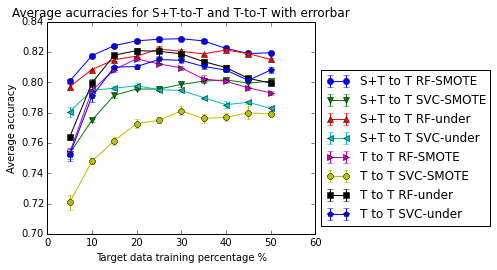

In [163]:
fig = plt.figure()
ax = fig.add_subplot(111)
curve_plot = np.mean(Learning_curves,axis=0)
std_err = sem(Learning_curves)

for index in range(0, curve_plot.shape[0]):
    #ax.plot(range(start_size,end_size,bins), Learning_accuracies, "s-",
    #            label=labels[index],marker = Line2D.filled_markers[index])
    ax.errorbar(range(start_size,end_size,bins), curve_plot[index],yerr=std_err[index],
                label=labels[index], marker = Line2D.filled_markers[index])
ax.set_title("Average acurracies for S+T-to-T and T-to-T with errorbar")
ax.set_xlabel("Target data training percentage %")
ax.set_ylabel("Average accuracy")

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height*0.95])

# Put a legend to the right of the current axis
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.8))
plt.show()

--------------------------Double check if the data is noisy (something wrong with the sampling method)---------------------

In [179]:
#change constant value
start_size = 5
end_size = 100
bins = 5
iter_time1 = 50
iter_time2 = 25

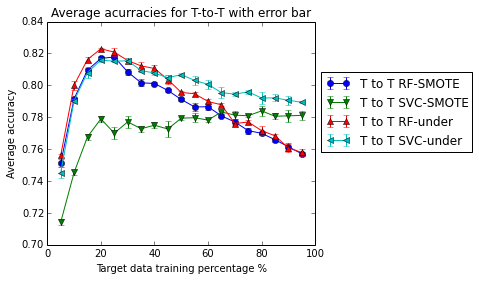

In [180]:
fig = plt.figure()
ax = fig.add_subplot(111)
runs = 4
Learning_curves = []
labels = []
for run in range(0,runs):
    Learning_curve = []
    '''Domain Adaptation Baseline Test 2 Target to Target'''
    for clf, name, data, sample_method in [(rfc, 'RF-SMOTE', ptfr, "SMOTE"),
                            (svc, 'SVC-SMOTE', ptfr_norm, "SMOTE"),
                            (rfc, 'RF-under', ptfr, "under"),
                            (svc, 'SVC-under', ptfr_norm, "under")]:    
        Learning_accuracies, clf, Feature_importance = Domain_Adaptation2(pd.DataFrame(), data, clf, sample_method)
        Learning_curve.append(Learning_accuracies)
        labels.append("T to T %s" % (name, ))
        '''
        ax.plot(range(start_size,end_size,bins), Learning_accuracies, "s-",
                 label="T to T %s" % (name, ), marker = Line2D.filled_markers[index])
        index += 1
        '''
    Learning_curves.append(np.array(Learning_curve))

curve_plot = np.mean(Learning_curves,axis=0)
std_err = sem(Learning_curves)

for index in range(0, curve_plot.shape[0]):
    #ax.plot(range(start_size,end_size,bins), Learning_accuracies, "s-",
    #            label=labels[index],marker = Line2D.filled_markers[index])
    ax.errorbar(range(start_size,end_size,bins), curve_plot[index], yerr=std_err[index], 
                label=labels[index], marker = Line2D.filled_markers[index])
    
ax.set_title("Average acurracies for T-to-T with error bar")
ax.set_xlabel("Target data training percentage %")
ax.set_ylabel("Average accuracy")

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.8))
plt.show()